## Analyis of EMEP Source-receptor tables v. 23.08.2024

## Introduction: 
The EMEP program is a scientifically based and policy-driven initiative under the Convention on Long-range Transboundary Air Pollution (CLRTAP) for international cooperation in solving transboundary air pollution problems. This program shares with the scientific community Source-Receptor (SR) tables, which are calculated using the EMEP MSC-W model. The model is based on meteorological data from ECMWF-IFS and covers the EMEP domain (30°N–82°N latitude, 30°W–90°E longitude) with a 0.3°×0.2° longitude-latitude resolution. These tables illustrate the changes in air concentrations or depositions due to variations in emissions from each country, calculated using the 15% perturbation method. They address two fundamental questions about transboundary air pollution: Where do the pollutants emitted by a country or region end up? Where do the pollutants in a given country or region come from?.  The changes in PM2.5 concentrations are computed on a perturbation of 15% of emission reductions, for pollutants such as SOx, NOx, NH3, NMVOC, and PPM that are primary source of PM2.5.
Source: Elaborated on https://www.emep.int/

This notebook reads the data presented in the SR Tables for PM2.5 from the years 2012 to 2021. The data has been previously processed in an Excel file called "PanelSR.xlsx".

In [1]:
# Import libraries
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization and plotting
import seaborn as sns  # For enhanced data visualization (based on matplotlib)
import numpy as np  # For numerical operations, especially working with arrays and mathematical functions like log
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load the dataset
file_path = 'C:/Users/uribep_a/model/EMEPmodel/PanelSR.xlsx'
df_raw = pd.read_excel(file_path)
# Selection of specific dataset by filtering
#df = df_raw[(df_raw['include'] == 1) & (df_raw['transboundary'] == 0)]
df = df_raw[(df_raw['include'] == 1) ]
# Prepare the data
important_columns = [
    'Name_Emitters',
    'ID_Emitters',
    'Code_Emitters',
    'DeltaPM25_ngperm3',
    'Year',
    'PrimaryPollutant',
    'Emission_Gg',
    'DeltaEmission_Gg',
    'DeltaPM25_ngperm3_per1Gg',
    'HaversineDistance'
]


## 1. Emissions: 
The variable Emission_Gg contains the emissions of each pollutant contributing to PM2.5 released in each country per year. These values are used to compute the perturbation on PM2.5 concentrations using 15% of these values, according to EMEP.

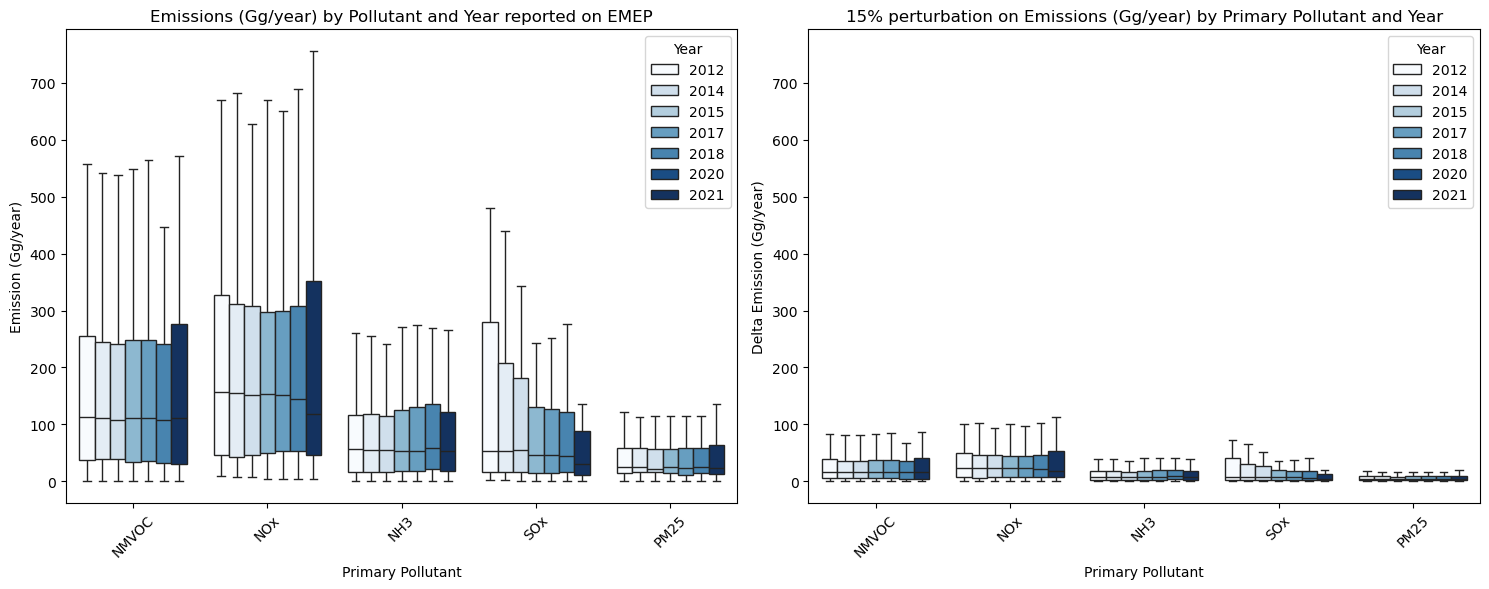

In [2]:
filtered_df_1 = df[important_columns]
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# First boxplot for Value_ngperm3 faceted by Year
sns.boxplot(x='PrimaryPollutant', y='Emission_Gg', hue='Year',data=filtered_df_1, showfliers=False, ax=axes[0], palette="Blues")
axes[0].set_title('Emissions (Gg/year) by Pollutant and Year reported on EMEP')
axes[0].set_xlabel('Primary Pollutant')
axes[0].set_ylabel('Emission (Gg/year)')
axes[0].tick_params(axis='x', rotation=45)

# Second boxplot for Value_ngperm3_per1Gg faceted by Year
sns.boxplot(x='PrimaryPollutant', y='DeltaEmission_Gg', hue='Year', data=filtered_df_1, showfliers=False, ax=axes[1], palette="Blues")
axes[1].set_title('15% perturbation on Emissions (Gg/year) by Primary Pollutant and Year')
axes[1].set_xlabel('Primary Pollutant')
axes[1].set_ylabel('Delta Emission (Gg/year)')
axes[1].tick_params(axis='x', rotation=45)

# Set the same y-axis limits for both plots
y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

##### Time trends. Is there a time trend? 
##### Model 1: 
To assess the presence of a time trend in emissions, we start by running a simple Ordinary Least Squares (OLS) regression model where the dependent variable is emissions (Emission_Gg), and the independent variable is time (Year). This basic model helps us understand if there is a general trend over time across all countries.

In [3]:
# Define the dependent variable (Emissions) and independent variable (Year)
y = filtered_df_1['Emission_Gg']
X = filtered_df_1['Year']
# Add a constant to the independent variable matrix (for the intercept)
X = sm.add_constant(X)
# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()
# Print the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Emission_Gg   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     54.49
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           1.58e-13
Time:                        10:21:31   Log-Likelihood:            -7.5718e+05
No. Observations:              101514   AIC:                         1.514e+06
Df Residuals:                  101512   BIC:                         1.514e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6975.8303    916.332      7.613      0.0

Is there a time trend?  Yes, but it’s weak (with model 1). 
The regression results from model 1 suggest that there is a statistically significant time trend in emissions over the years, with emissions decreasing slightly over time. However, the trend is weak, as indicated by the very low R-squared value. What Next?

##### Model 2:  
We improve model 1 by adding country-specific fixed effects. This involves including dummy variables for each country in the dataset. These dummies capture the unique characteristics of each country that could influence emissions but are not directly observed in the data (such as policies, economic conditions, industrial practices, etc.). These are controlling for unobserved heterogeneity. Model 2 now focuses on within-country variations over time, rather than between-country differences. Model 2 now accounts for more of the variance in emissions that can be attributed to differences between countries.

In [4]:
# Recreate dummy variables
X = pd.concat([
    filtered_df_1[['Year']],
    pd.get_dummies(filtered_df_1['ID_Emitters'], drop_first=True)
], axis=1)
# Ensure that all boolean columns are explicitly converted to integers
for col in X.columns[1:]:  # Skip the first column 'Year' assuming it's numeric
    X[col] = X[col].astype(int)

# Add a constant to the independent variable matrix (for the intercept)
X = sm.add_constant(X)
# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()
# Print the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Emission_Gg   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     3302.
Date:                Fri, 23 Aug 2024   Prob (F-statistic):               0.00
Time:                        10:21:32   Log-Likelihood:            -7.0573e+05
No. Observations:              101514   AIC:                         1.412e+06
Df Residuals:                  101459   BIC:                         1.412e+06
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7187.9395    552.254     13.016      0.0

##### Interpretation of Time Trend of Emissions: 
The coefficient for Year is -3.5561, which is slightly more negative than in the simple OLS model without fixed effects. This indicates that, after controlling for country-specific factors, emissions are still decreasing over time, but the trend is more pronounced. Adding country-specific fixed effects accounts for unobserved heterogeneity between countries, improving the model’s explanatory power. There is an average decrease in emissions of approximately 3.6 gigagrams (Gg) per year. Model 2 now explains about 63.7% of the variance in emissions (R-squared), which is a substantial improvement over the simple OLS model that only included Year. With fixed effects included, the time trend (Year coefficient) reflects within-country changes in emissions over time, independent of the country-specific baseline differences. This makes the time trend more accurate and meaningful.

##### Analyis by Polluntat:
We now replicate this analysis for each pollutant separately, including fixed effects by country.

In [5]:
# Get the unique pollutants in the dataset
unique_pollutants = filtered_df_1['PrimaryPollutant'].unique()
# Initialize a list to store the results
results_summary = []
# Loop through each pollutant and perform OLS regression
for pollutant in unique_pollutants:
    #print(f"\nRunning OLS for pollutant: {pollutant}")
    # Filter the DataFrame for the current pollutant
    filtered_df_pollutant = filtered_df_1[filtered_df_1['PrimaryPollutant'] == pollutant]
    # Define the dependent variable (Emissions) and independent variable (Year)
    y = filtered_df_pollutant['Emission_Gg']
     # Recreate dummy variables
    X = pd.concat([
        filtered_df_pollutant[['Year']],
        pd.get_dummies(filtered_df_pollutant['ID_Emitters'], drop_first=True)
    ], axis=1)
    # Ensure that all boolean columns are explicitly converted to integers
    for col in X.columns[1:]:  # Skip the first column 'Year' assuming it's numeric
        X[col] = X[col].astype(int)
    # Add a constant to the independent variable matrix (for the intercept)
    X = sm.add_constant(X)
    # Fit the OLS model
    model = sm.OLS(y, X)
    results = model.fit()
    # Extract the coefficient, p-value, and confidence interval for 'Year'
    year_coef = results.params['Year']
    p_value = results.pvalues['Year']
    conf_int = results.conf_int().loc['Year']
    # Append the results to the summary list
    results_summary.append({
        'Pollutant': pollutant,
        'Year Coefficient': year_coef,
        'P-value': p_value,
        '95% CI Lower': conf_int[0],
        '95% CI Upper': conf_int[1]
    })
# Convert the summary list into a DataFrame for easy viewing
results_df = pd.DataFrame(results_summary)
# Display the summary table
print(results_df)

  Pollutant  Year Coefficient        P-value  95% CI Lower  95% CI Upper
0     NMVOC         -2.198085  1.028148e-151     -2.360914     -2.035256
1       NOx         -5.811668   0.000000e+00     -6.018065     -5.605272
2       NH3          0.677531   3.375542e-78      0.606901      0.748161
3       SOx         -9.729357   0.000000e+00    -10.040161     -9.418552
4      PM25         -1.049556   0.000000e+00     -1.090634     -1.008477


##### Interpretation: 
Downward Trends: For pollutants like NMVOC, NOx, SOx, and PM2.5, the negative year coefficients indicate significant reductions in emissions over time. These reductions could be due to improvements in technology, regulatory measures, or other environmental policies aimed at reducing emissions.
Upward Trend: NH3 is the exception, showing an increase in emissions over time. This could point to rising use of ammonia in agriculture (e.g., as fertilizer) or other industrial processes that have not been as strictly regulated or mitigated as the other pollutants.
Statistical Significance: The extremely low p-values across all pollutants suggest that these trends are highly statistically significant and not due to random variation.

## 2. Changes in PM2.5 concentrations 
Changes in PM2.5 concentrations are computed based on a 15% reduction in emissions for pollutants such as SOx, NOx, NH3, NMVOC, and PPM, which are primary sources of PM2.5. The goal is to understand both the magnitude and the nature of the impact that emission reductions have on air quality, as measured by changes in PM2.5 concentrations.

In [6]:
# Import libraries
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization and plotting
import seaborn as sns  # For enhanced data visualization (based on matplotlib)
import numpy as np  # For numerical operations, especially working with arrays and mathematical functions like log
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load the dataset
file_path = 'C:/Users/uribep_a/model/EMEPmodel/PanelSR.xlsx'
df_raw = pd.read_excel(file_path)

df = df_raw[(df_raw['include'] == 1) & (df_raw['transboundary'] == 0)]
# Prepare the data
important_columns = [
    'Name_Emitters',
    'ID_Emitters',
    'Code_Emitters',
    'DeltaPM25_ngperm3',
    'Year',
    'PrimaryPollutant',
    'Emission_Gg',
    'DeltaEmission_Gg',
    'DeltaPM25_ngperm3_per1Gg',
    'HaversineDistance'
]
filtered_df_1 = df[important_columns]

We plot at the left side the change 15% reduction in emissions, and at the rigth side the changes on changes in PM2.5 concentrations according data from EMEP Source-receptor tables for PM2.5

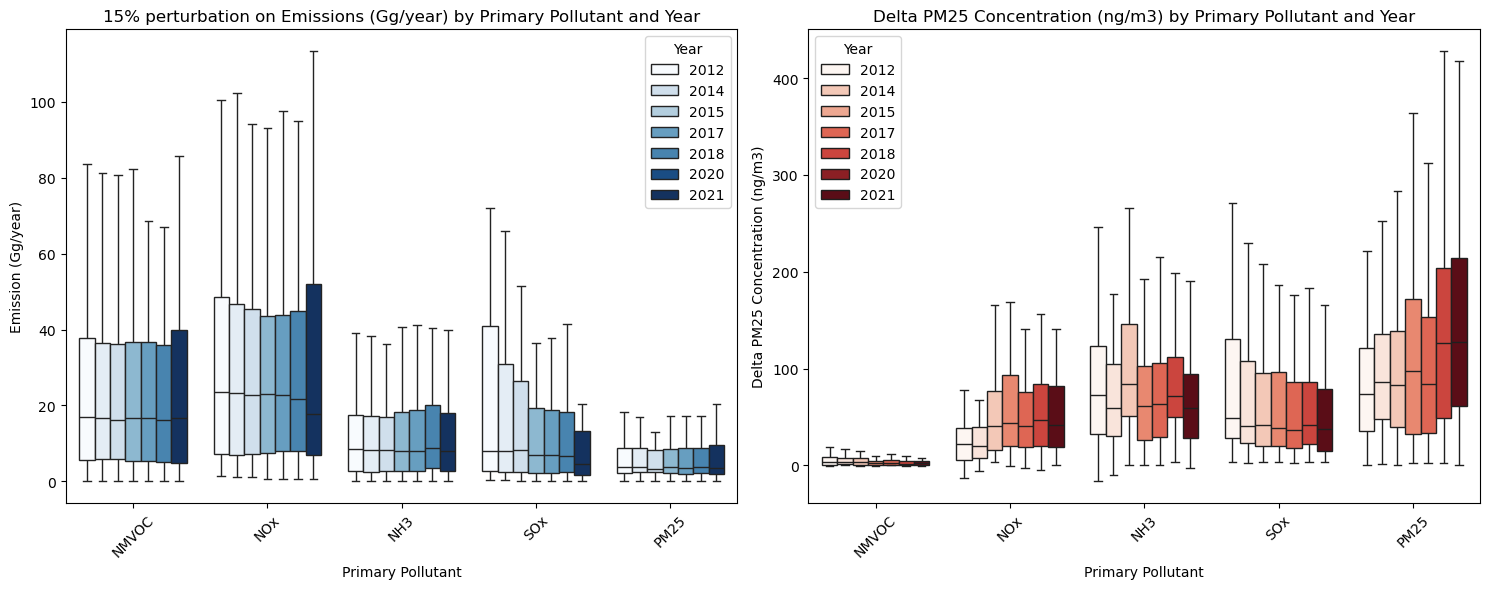

In [7]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# First boxplot for Value_ngperm3 faceted by Year
sns.boxplot(x='PrimaryPollutant', y='DeltaEmission_Gg', hue='Year', data=filtered_df_1, showfliers=False, ax=axes[0], palette="Blues")
axes[0].set_title('15% perturbation on Emissions (Gg/year) by Primary Pollutant and Year')
axes[0].set_xlabel('Primary Pollutant')
axes[0].set_ylabel('Emission (Gg/year)')
axes[0].tick_params(axis='x', rotation=45)

# Second boxplot for Value_ngperm3_per1Gg faceted by Year
sns.boxplot(x='PrimaryPollutant', y='DeltaPM25_ngperm3', hue='Year', data=filtered_df_1, showfliers=False, ax=axes[1], palette="Reds")
axes[1].set_title('Delta PM25 Concentration (ng/m3) by Primary Pollutant and Year')
axes[1].set_xlabel('Primary Pollutant')
axes[1].set_ylabel('Delta PM25 Concentration (ng/m3)')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

We connect both variables and try to understand the relationship between them.

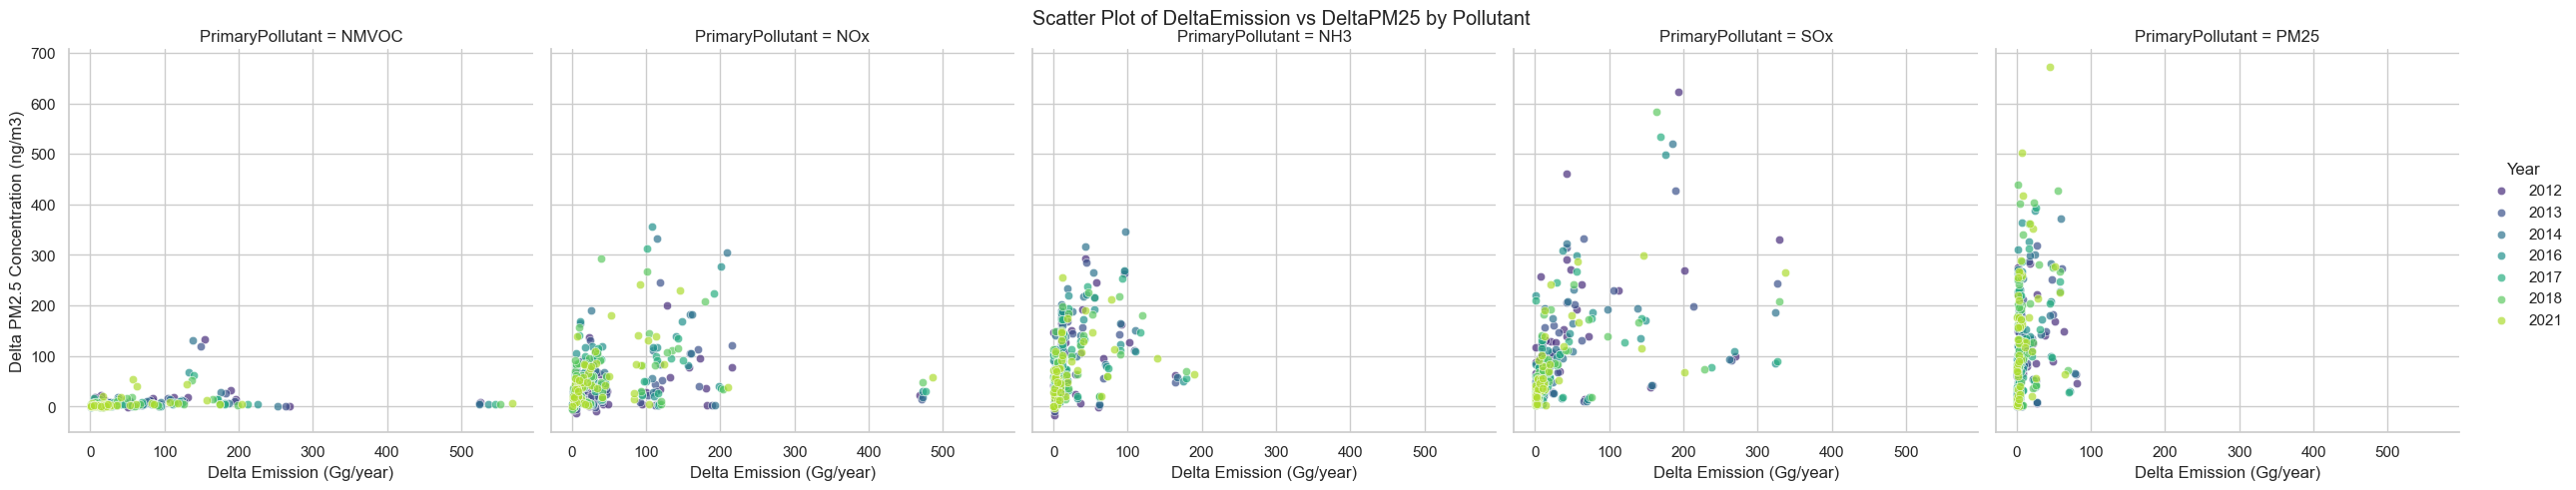

In [8]:
# Set up the Seaborn theme for aesthetics
sns.set_theme(style="whitegrid")
# Create a scatter plot for each pollutant
g = sns.FacetGrid(filtered_df_1, col="PrimaryPollutant", hue="Year", palette="viridis", height=5, aspect=1)
g.map(sns.scatterplot, "DeltaEmission_Gg", "DeltaPM25_ngperm3", alpha=0.7)
# Add a legend and adjust the layout
g.add_legend()
g.set_axis_labels("Delta Emission (Gg/year)", "Delta PM2.5 Concentration (ng/m3)")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Scatter Plot of DeltaEmission vs DeltaPM25 by Pollutant")
plt.show()

We include in our analysis the depictions by country for each year.

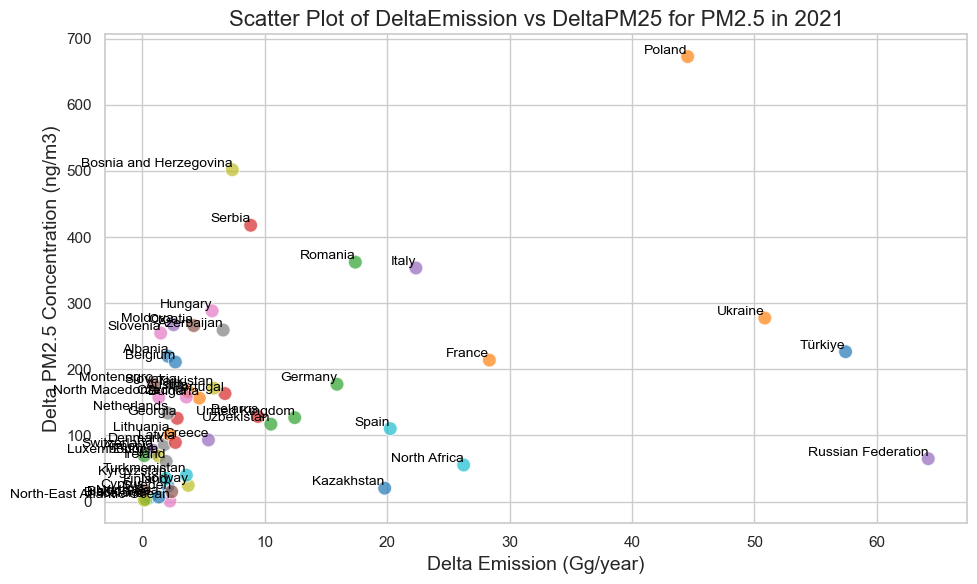

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# Filter the dataset for Year = 2021 and PrimaryPollutant = 'PM2.5'
filtered_df_2021_PM25 = filtered_df_1[(filtered_df_1['Year'] == 2021) & (filtered_df_1['PrimaryPollutant'] == 'PM25')]
# Create the scatter plot without showing the legend
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DeltaEmission_Gg', y='DeltaPM25_ngperm3', data=filtered_df_2021_PM25, hue='Name_Emitters', palette='tab10', s=100, alpha=0.7, legend=False)
# Add country names to each point
for i in range(filtered_df_2021_PM25.shape[0]):
    plt.text(x=filtered_df_2021_PM25['DeltaEmission_Gg'].iloc[i],
             y=filtered_df_2021_PM25['DeltaPM25_ngperm3'].iloc[i],
             s=filtered_df_2021_PM25['Name_Emitters'].iloc[i],
             fontdict=dict(color='black', size=10),
             ha='right', va='bottom')
# Add titles and labels
plt.title('Scatter Plot of DeltaEmission vs DeltaPM25 for PM2.5 in 2021', fontsize=16)
plt.xlabel('Delta Emission (Gg/year)', fontsize=14)
plt.ylabel('Delta PM2.5 Concentration (ng/m3)', fontsize=14)
# Display grid and adjust layout
plt.grid(True)
plt.tight_layout()
plt.show()